In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings

In [2]:
directory = '../data'

In [3]:
pits = pickle.load(open(f'{directory}/pickles/kuka_pits.p','rb'))

In [4]:
pits_ = pits.copy()

pits = {}

for key, value in pits_.items():
    
    pits[key] = value

In [5]:
def get_ymd_from_filename(filename):
    
    datestring = filename.split('Scat')[-1][:8]
    
    y = int(datestring[:4])
    m = int(datestring[4:6])
    d = int(datestring[6:8])
    
    return(y,m,d)
def get_time_index(time,times):
    
    deltas = np.array(times) - time

    secs = np.array([d.seconds for d in deltas])
    ms = np.array([d.microseconds for d in deltas])
    
    secs = secs + (ms * 1e-6)
    
    index = np.argmin(secs)
    
    return index


def get_range_index(input_range,ranges):
    
    deltas = np.array(ranges) - input_range
    
    index = np.argmin(np.abs(deltas))
    
    return index

def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks

In [6]:
for pitno, data_dict in pits.items():

    y,m,day = get_ymd_from_filename(pits[pitno]['file'])
    
    for freq in ['ka','ku']:

        start_time = datetime.datetime(y,m,day,data_dict[freq][0][0],data_dict[freq][0][1],data_dict[freq][0][2])
        end_time   = datetime.datetime(y,m,day,data_dict[freq][1][0],data_dict[freq][1][1],data_dict[freq][1][2])

        with Dataset(f'{directory}/ncs/{data_dict["file"]}') as d:
            ranges = np.array(d['range'])
            times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

            time_ticks = get_time_ticks(times)
            hh = np.array(d['hh_power_decon0'])
            hv = np.array(d['hv_power_decon0'])
            vh = np.array(d['vh_power_decon0'])
            vv = np.array(d['vv_power_decon0'])
            
            crosstilt = np.array(d['cross_tilt'])
            alongtilt = np.array(d['along_tilt'])
       
            start_ind = get_time_index(start_time,times)
            end_ind = get_time_index(end_time,times)
            
            pits[pitno][f'{freq}_hh'] = np.mean(hh[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_vv'] = np.mean(vv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_hv'] = np.mean(hv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_vh'] = np.mean(hv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_range'] = ranges
            
                 
            pits[pitno][f'{freq}crosstilt'] = np.mean(crosstilt[start_ind:end_ind])
            pits[pitno][f'{freq}alongtilt'] = np.mean(alongtilt[start_ind:end_ind])
       

In [8]:
ruler_measurements_from_plate = {'ka':1.595,'ku':1.573}

/home/robbie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/robbie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/robbie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/robbie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/robbie/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/robbie/anaconda3/lib/python3.9/site-packages/IPyt

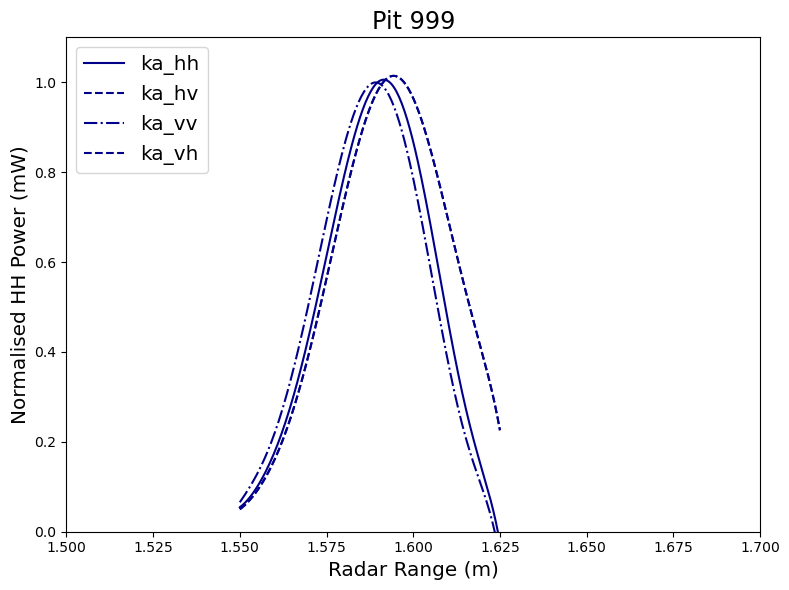

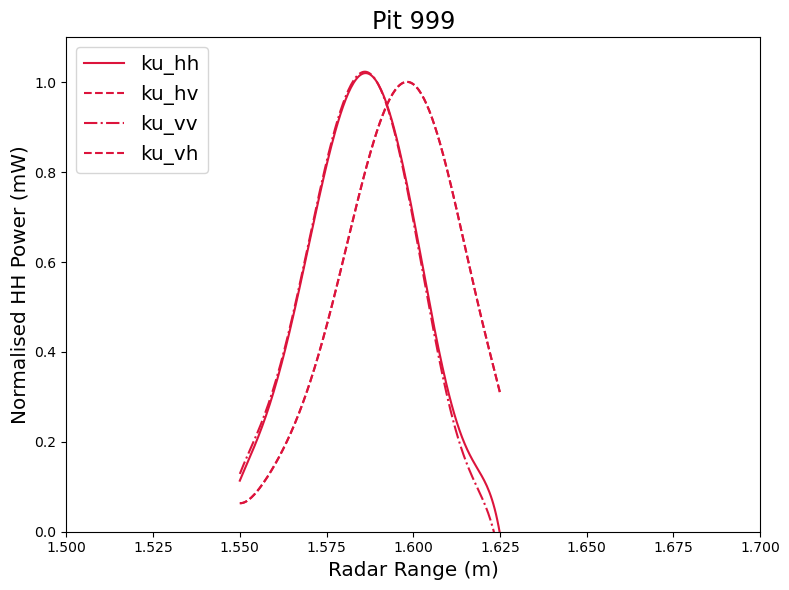

In [15]:
ll, ul = 1.55, 1.625
x = np.linspace(ll,ul,200)

ylims = {'ku':0.015,'ka':0.015}

pitno = 999

data_dict = pits[pitno]

offsets = {'ka':{},'ku':{}}

for freq,color in zip(['ka','ku'],['darkblue','crimson']):
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    
    for pol, ls in zip(['hh','hv','vv','vh'],['-','--','-.','--']):
    
        ranges = data_dict[f'{freq}_range']

        snow_line = data_dict[f'{freq}_{pol}']

        snow_line[ranges<1.2] = 0
        snow_line[ranges>4] = 0

#         ax.plot(ranges,snow_line/np.max(snow_line),color=color,label=f'{freq}_{pol}',ls=ls)
        
        p = (snow_line/np.max(snow_line))[(ranges>=ll) & (ranges<=ul)]
        r = ranges[(ranges>=ll) & (ranges<=ul)]
        
        poly = np.polyfit(r,p,deg=13)
        s = np.poly1d(poly)
        y = s(x)
        
        offsets[freq][pol] = x[np.argmax(y)] - ruler_measurements_from_plate[freq]
        
        ax.plot(x,y,color=color,ls=ls,label=f'{freq}_{pol}')

    ax.set_ylim(0,1.1)
    ax.set_ylabel(f'Normalised HH Power (mW)',fontsize='x-large')
    ax.legend(fontsize='x-large',loc='upper left')


    ax.set_xlim(1.5,1.7)
    ax.set_xlabel('Radar Range (m)',fontsize='x-large')

    plt.title(f'Pit {pitno}',fontsize='xx-large')

    plt.tight_layout()

#     plt.savefig(f'../figures/slush_{pitno}.jpg',dpi=400)

In [16]:
offsets

{'ka': {'hh': -0.0035427135678391952,
  'hv': -0.0005276381909546934,
  'vv': -0.005804020100502516,
  'vh': -0.0005276381909546934},
 'ku': {'hh': 0.013180904522613224,
  'hv': 0.025241206030150787,
  'vv': 0.013180904522613224,
  'vh': 0.025241206030150787}}

In [17]:
pickle.dump(offsets,open('../data/pickles/offsets.p','wb'))